![Piggy bank](img/piggy_bank.jpg)

Personal loans are a lucrative revenue stream for banks. The typical interest rate of a two-year loan in the United Kingdom is [around 10%](https://www.experian.com/blogs/ask-experian/whats-a-good-interest-rate-for-a-personal-loan/). This might not sound like a lot, but in September 2022 alone UK consumers borrowed [around £1.5 billion](https://www.ukfinance.org.uk/system/files/2022-12/Household%20Finance%20Review%202022%20Q3-%20Final.pdf), which would mean approximately £300 million in interest generated by banks over two years!

You have been asked to work with a bank to clean the data they collected as part of a recent marketing campaign, which aimed to get customers to take out a personal loan. They plan to conduct more marketing campaigns going forward so would like you to ensure it conforms to the specific structure and data types that they specify so that they can then use the cleaned data you provide to set up a PostgreSQL database, which will store this campaign's data and allow data from future campaigns to be easily imported. 

They have supplied you with a csv file called `"bank_marketing.csv"`, which you will need to clean, reformat, and split the data, saving three final csv files. Specifically, the three files should have the names and contents as outlined below:

## `client.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `age` | `integer` | Client's age in years | N/A |
| `job` | `object` | Client's type of job | Change `"."` to `"_"` |
| `marital` | `object` | Client's marital status | N/A |
| `education` | `object` | Client's level of education | Change `"."` to `"_"` and `"unknown"` to `np.NaN` |
| `credit_default` | `bool` | Whether the client's credit is in default | Convert to `boolean` data type:<br> `1` if `"yes"`, otherwise `0` |
| `mortgage` | `bool` | Whether the client has an existing mortgage (housing loan) | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0` |

<br>

## `campaign.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `number_contacts` | `integer` | Number of contact attempts to the client in the current campaign | N/A |
| `contact_duration` | `integer` | Last contact duration in seconds | N/A |
| `previous_campaign_contacts` | `integer` | Number of contact attempts to the client in the previous campaign | N/A |
| `previous_outcome` | `bool` | Outcome of the previous campaign | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0`. |
| `campaign_outcome` | `bool` | Outcome of the current campaign | Convert to boolean data type:<br> `1` if `"success"`, otherwise `0`. |
| `last_contact_date` | `datetime` | Last date the client was contacted | Create from a combination of `day`, `month`, and a newly created `year` column (which should have a value of `2022`); <br> **Format =** `"YYYY-MM-DD"` |

<br>

## `economics.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `cons_price_idx` | `float` | Consumer price index (monthly indicator) | N/A |
| `euribor_three_months` | `float` | Euro Interbank Offered Rate (euribor) three-month rate (daily indicator) | N/A |

In [494]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Step 1: Load the data**

In [495]:
bank_df = pd.read_csv('bank_marketing.csv')

## **Step 2: Data Exploration**

In [496]:
# Get initial insights into the data
print("**head()**\n",bank_df.head())
print("\n**shape**\n",bank_df.shape)
print("\n**describe()**\n",bank_df.describe())
print("\n**info()**\n",bank_df.info())
print("\n**isnull().sum()**\n",bank_df.isnull().sum())

**head()**
    client_id  age  ... euribor_three_months campaign_outcome
0          0   56  ...                4.857               no
1          1   57  ...                4.857               no
2          2   37  ...                4.857               no
3          3   40  ...                4.857               no
4          4   56  ...                4.857               no

[5 rows x 16 columns]

**shape**
 (41188, 16)

**describe()**
          client_id          age  ...  cons_price_idx  euribor_three_months
count  41188.00000  41188.00000  ...    41188.000000          41188.000000
mean   20593.50000     40.02406  ...       93.575664              3.621291
std    11890.09578     10.42125  ...        0.578840              1.734447
min        0.00000     17.00000  ...       92.201000              0.634000
25%    10296.75000     32.00000  ...       93.075000              1.344000
50%    20593.50000     38.00000  ...       93.749000              4.857000
75%    30890.25000     47.00000  

### Value counts for deeper understanding of categorical feature distributions

In [497]:
for col in bank_df.select_dtypes(include='object'):
    print(f"\n**Value counts for '{col}':**")
    print(bank_df[col].value_counts())


**Value counts for 'job':**
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

**Value counts for 'marital':**
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

**Value counts for 'education':**
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

**Value counts for 'credit_default':**
no         32588
unknown     8597
yes            3
Name: credit_default, dtype: int64

**Value counts for 'mortgage':**
yes        21576
no         18622
unknown      990
Name: mortgage, dtype: int64



## **Step 3: Data Visualization**

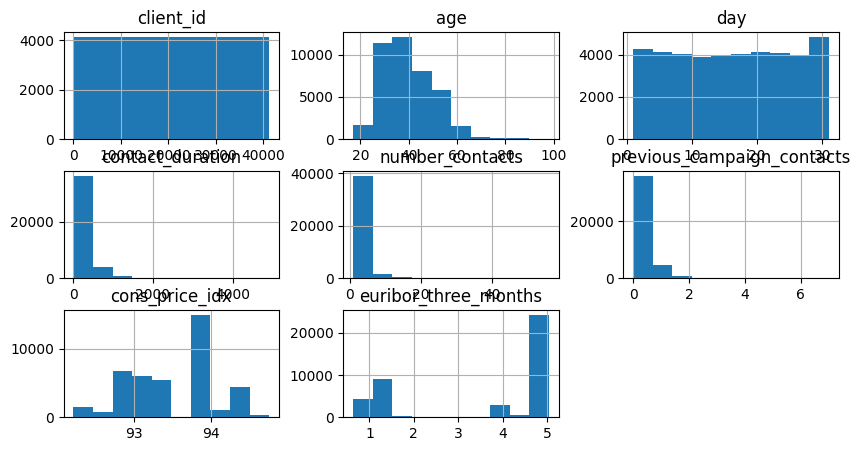

In [498]:
bank_df.hist(figsize=(10, 5))
plt.show()

## **Step 4: Split the data into separate DataFrames**

In [499]:
client = bank_df[['client_id', 'age', 'job', 'marital', 'education', 'credit_default', 'mortgage']]

campaign = bank_df[["client_id", "number_contacts", "contact_duration", "previous_campaign_contacts", "previous_outcome", "campaign_outcome", 'day', 'month']]

economics = bank_df[["client_id", "cons_price_idx", "euribor_three_months"]]


## **Step 5: Data Cleaning and Transformations**

### Client DataFrame

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `age` | `integer` | Client's age in years | N/A |
| `job` | `object` | Client's type of job | Change `"."` to `"_"` |
| `marital` | `object` | Client's marital status | N/A |
| `education` | `object` | Client's level of education | Change `"."` to `"_"` and `"unknown"` to `np.NaN` |
| `credit_default` | `bool` | Whether the client's credit is in default | Convert to `boolean` data type:<br> `1` if `"yes"`, otherwise `0` |
| `mortgage` | `bool` | Whether the client has an existing mortgage (housing loan) | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0` |

#### Replace '.' with '_' in job and education

In [500]:
client['job'] = client['job'].str.replace('.', '_')
client['education'] = client['education'].str.replace('.', '_')

#### Replace 'unknown' in education with NaN

In [501]:
client['education'] = client['education'].replace('unknown', np.NaN)

#### Convert credit_default and mortgage to booleans

In [502]:
client['credit_default'] = client['credit_default'].map({'yes': 1, 'no': 0, 'unknown' : 0})
client['mortgage'] = client['mortgage'].map({'yes': 1, 'no': 0, 'unknown' : 0})

In [503]:
client['credit_default'] = client['credit_default'].astype(bool)
client['mortgage'] = client['mortgage'].astype(bool)

### Campaign DataFrame

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `number_contacts` | `integer` | Number of contact attempts to the client in the current campaign | N/A |
| `contact_duration` | `integer` | Last contact duration in seconds | N/A |
| `previous_campaign_contacts` | `integer` | Number of contact attempts to the client in the previous campaign | N/A |
| `previous_outcome` | `bool` | Outcome of the previous campaign | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0`. |
| `campaign_outcome` | `bool` | Outcome of the current campaign | Convert to boolean data type:<br> `1` if `"success"`, otherwise `0`. |
| `last_contact_date` | `datetime` | Last date the client was contacted | Create from a combination of `day`, `month`, and a newly created `year` column (which should have a value of `2022`); <br> **Format =** `"YYYY-MM-DD"` |

#### Convert previous_outcome and campaign_outcome to booleans

In [504]:
campaign['previous_outcome'] = campaign['previous_outcome'].map({'success': 1, 'failure': 0, 'nonexistent': 0})
campaign['campaign_outcome'] = campaign['campaign_outcome'].map({'yes': 1, 'no': 0})

In [505]:
campaign['previous_outcome'] = campaign['previous_outcome'].astype(bool)
campaign['campaign_outcome'] = campaign['campaign_outcome'].astype(bool)

#### Create the last_contact_date column

In [506]:
# Assign a fixed year
campaign['year'] = 2022

In [507]:
# Convert the 'month' column using a dictionary
month_dict = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

campaign['month'] = campaign['month'].apply(lambda x: month_dict[x.lower()])  

campaign['last_contact_date'] = pd.to_datetime(campaign[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d')

In [508]:
# Drop unnecessary columns
campaign.drop(columns=['year', 'month', 'day'], inplace=True)

## **Step 6: Save cleaned DataFrames to CSV**

In [509]:
client.to_csv('client.csv', index=False)
campaign.to_csv('campaign.csv', index=False)
economics.to_csv('economics.csv', index=False)